# Importation des bibiotheques

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Convolution3DTranspose,BatchNormalization
from tensorflow.keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose,Conv3DTranspose, ReLU, LeakyReLU, Dropout # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization 


# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator
# Other utilities
import sys

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])
print(main_dir)

2022-09-01 11:57:18.753818: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 11:57:18.753844: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow/Keras: 2.9.0
numpy: 1.23.0
sklearn: 1.1.1
/home/bahri-khalid/Projects/3D_VAE_GAN


# Definition des fonctions pour preparer la bonne fomate de donnees

In [2]:
# This function is to visualize the voxels
alpha = 0.5
linewidth = 0.8
axisoff=False,
def visualizeVxl(voxels):
    voxels.shape=(32,32,32)
    ax = plt.figure(figsize=(50,50)).add_subplot(projection='3d')
    ax.voxels(voxels, facecolors='crimson', edgecolor='k')
    if axisoff:
        ax.set_axis_off()
    plt.show()

In [3]:
# This function is to get the vox formate
def GetVox(mesh_path):
    mat = scipy.io.loadmat(mesh_path)
    vox = mat['instance']
    return vox

In [4]:
def correctShape(obj):
    big = np.zeros((32,32,32))
    big[:30,:30,:30] = obj
#     big.shape
    return big

In [5]:
# this function is to convert .mat into numpy array and store it under the .npy formate
def make_npy_df():
    objects = list(os.walk('../data/raw/chair/30/train/'))[0][2]
    for obj in objects:
        vox = GetVox('../data/raw/chair/30/train/'+obj)
        vox = correctShape(vox)
        np.save('../data/processed/'+obj.split('.')[0],vox)

In [6]:
# make_npy_df() #call once

In [7]:
data_path = main_dir + '/data/processed/'
data = np.array([np.load(data_path+x,allow_pickle=True) for x in list(os.walk(data_path))[0][2]  ])
# let's take only 300 of them 
data = data[:300,:,:,:]
data[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

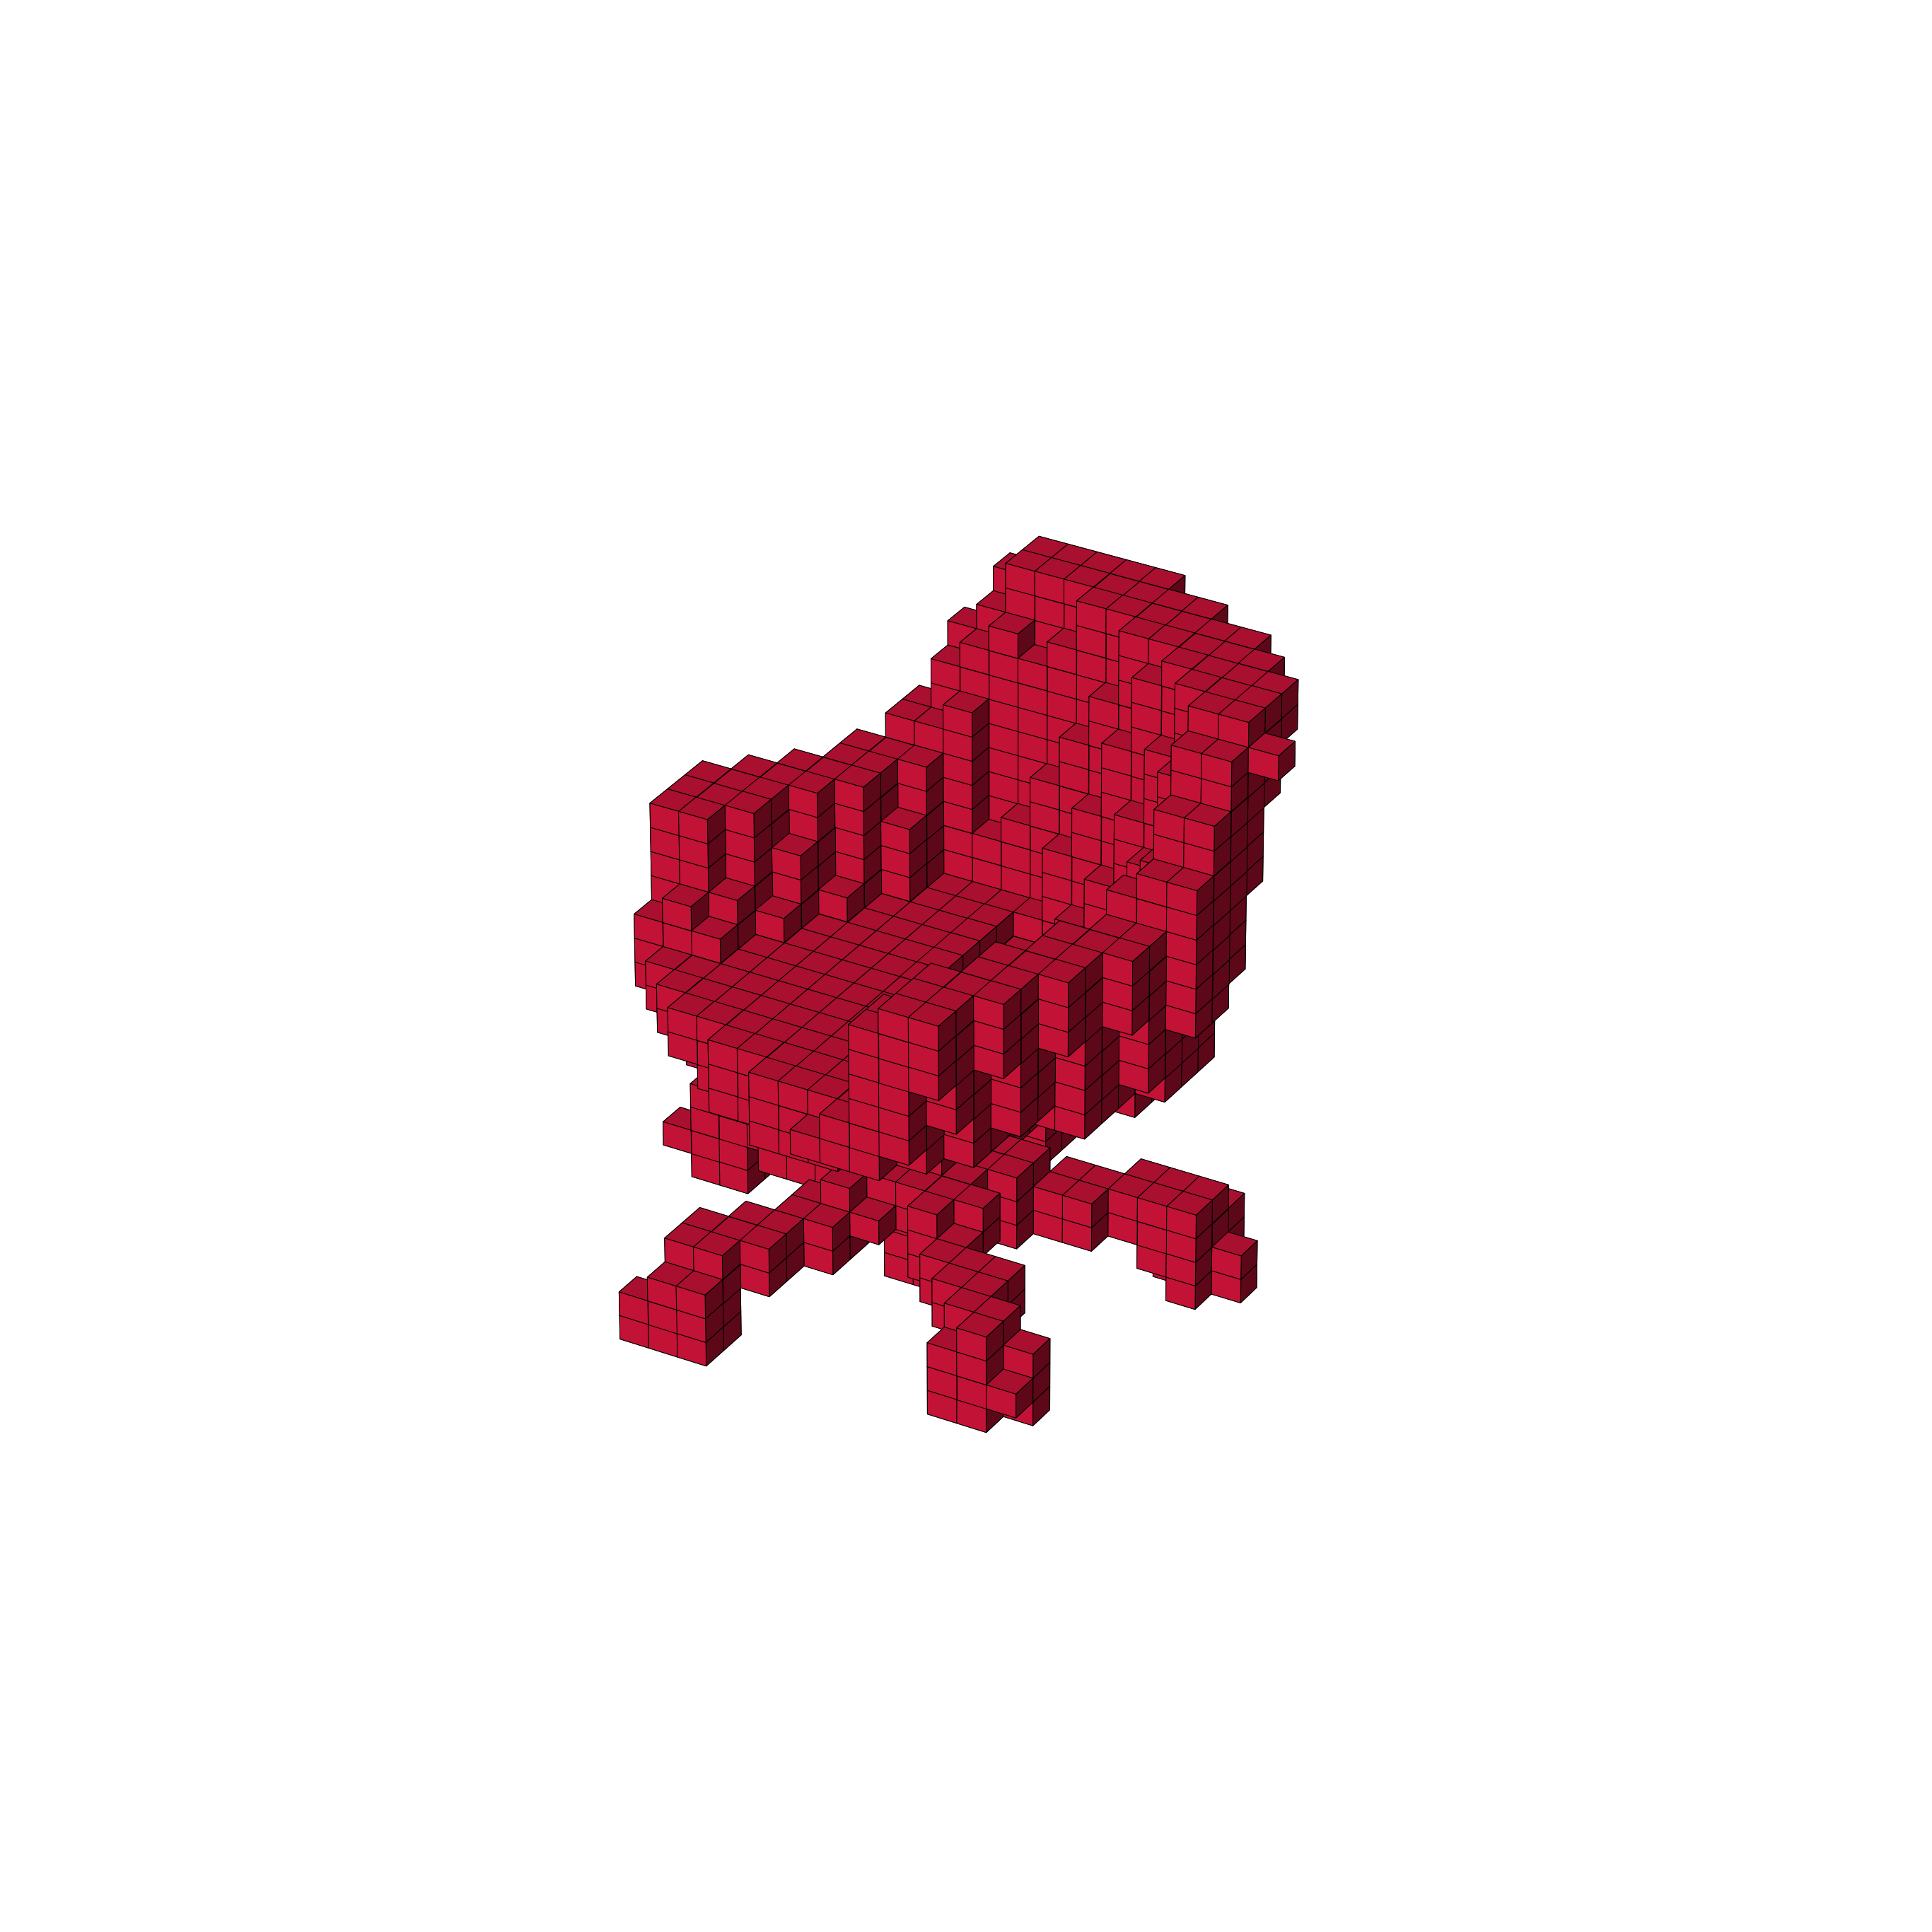

(32, 32, 32)

In [10]:
visualizeVxl(data[0])
data[0].shape

# Preparer le GAN

In [11]:
def generator(latent_dim):
    model = Sequential(name="Generator") # Model

    n_nodes = 4 * 4 * 4 * 128 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(Reshape((4,4, 4, 128)))
    
    model.add(Conv3DTranspose(filters=128, kernel_size=(5,5,5), strides=(2,2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
                              

    model.add(Conv3DTranspose(filters=256, kernel_size=(5,5,5), strides=(2,2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    

    model.add(Conv3DTranspose(filters=512, kernel_size=(5,5,5), strides=(2,2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv3D(filters=1, kernel_size=(5,5,5), activation='tanh', padding='same', name='Generator-Output-Layer'))
    return model

# Instantiate
latent_dim=100 
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400) #, to_file='generator_structure.png')

2022-09-01 11:58:06.052116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-01 11:58:06.052148: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-01 11:58:06.052179: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bahrikhalid-ThinkPad-X1-Carbon-6th): /proc/driver/nvidia/version does not exist
2022-09-01 11:58:06.052985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 4, 4, 4, 128)      0         
                                                                 
 conv3d_transpose (Conv3DTra  (None, 8, 8, 8, 128)     2048128   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 8, 128)     512       
 hNormalization)                                                 
                                                         

In [12]:
def discriminator(in_shape=(32,32,32,1)):
    model = Sequential([
        layers.Conv3D(16, (5,5,5), activation='relu', padding='same', input_shape=in_shape),
        layers.Conv3D(32, (5,5,5), activation='relu', padding='same'),
        layers.BatchNormalization(),
    #     layers.MaxPooling3D((2,2,2), padding='same'),

        layers.Conv3D(64, (5,5,5), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv3D(128, (5,5,5), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv3D(128, (5,5,5), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Dense(units = 256, activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),

        layers.Dense(units=1, activation='sigmoid'),
    ])
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400) #, to_file='discriminator_structure.png')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 32, 32, 16)    2016      
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 32, 32, 32)    64032     
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32, 32)   128       
 hNormalization)                                                 
                                                                 
 conv3d_2 (Conv3D)           (None, 32, 32, 32, 64)    256064    
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 32, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_3 (Conv3D)           (None, 32, 32, 32, 128)   1

# GAN

In [13]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Combine
    model = Sequential(name="DCGAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400) #, to_file='dcgan_structure.png')

Model: "DCGAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 32, 32, 32, 1)     23456641  
                                                                 
 sequential (Sequential)     (None, 1)                 11818433  
                                                                 
Total params: 35,275,074
Trainable params: 23,438,465
Non-trainable params: 11,836,609
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [52]:
# Sample the real 3d objects
def real_samples(n, dataset):
    
    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))
    X.shape = (X.shape[0],32,32,32,1)
    return X, y

In [15]:
# Generate points in the latent space
def latent_vector(latent_dim, n):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input

In [19]:
# Generate fake 3d samples using the generator
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)
    
    # Create class labels
    y = np.zeros((n, 1))
    return X, y

In [20]:
# This function is to let us keep track of the performance of the model
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    
    # Create a 2D scatter plot to show real and fake (generated) data points
    visualizeVxl(x_fake[10])

In [54]:
# Now let difine the function that will train the model
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=500, n_batch=32, n_eval=100):
    
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        print(x_real.shape)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        print(x_fake.shape)
        # Train the discriminator using real and fake samples
        X = np.vstack((x_real, x_fake))
        y = np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)
    
    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

In [ ]:
train(gen_model, dis_model, gan_model, data, latent_dim)

(16, 32, 32, 32, 1)
1/1 [==============================] - 56s 56s/step
(16, 32, 32, 32, 1)


In [53]:
x,y =real_samples(3,data)
x.shape

(3, 32, 32, 32, 1)

In [48]:
x,y = fake_samples(gen_model,100,3)


1/1 [==============================] - 9s 9s/step


(3, 32, 32, 32, 1)